# Analyzing Empirical Data for Comparison Between node2vec Implementations
### Agustin Lorenzo, Jonathan Sanderford




## Introduction
### node2vec
*node2vec* is a semi-supervised algorithm for scalable feature learning of networks. Previous methods employed supervised machine learning, but this required expert knowledge to hand-engineer features and results were not generalizable. Other attempts at unsupervised learning came to difficulties with defining and optimizing an objective function. As for sampling strategies, two extreme classical approaches employed `BFS` and `DFS`, but each came with their advantages and disadvantages. *node2vec*'s key contribution comes from its utilization of biased random walks to explore neighborhoods in both a `BFS` and `DFS` fashion.
### PecanPy
*node2vec* provides a great start in solving the original problem of unsupervised feature learning of networks, but it has still left room for improvement and optimization. Since its creation, a number of subsequent implementations have claimed to improve upon the efficacy of the original implementation in Python and C++. Most notably, *PecanPy* is a popular implementation of the *node2vec* algorithm that claims to improve both the time and space complexity.
### Project goals
We hope to expand upon the original paper proposing the *node2vec* algorithm, *node2vec: Scalable Feature Learning for Networks*, by evaluating if one subsequent implementation has improved upon the original. Specifically, we will be analyzing the time complexity of the two algorithms. We will make use of both the original *node2vec* algorithm along with the *PecanPy* implementation to gather empirical data on the time required for learning from each algorithms. With this data we will analyze the difference between the two implementations through a one-sided t-test.
#### Hypothesies ($\alpha = 0.05$)
> $H_0:$ There is no difference between the time's required for learning from both the original *node2vec* algorithm and the *PecanPy* implementation. <br>
> $H_a:$ The time required for learning for the *PecanPy* implementation is lower than the time required for the original *node2vec* algorithm.

In [15]:
# Importing all required packages
import time
import csv
import pecanpy
import os
import linecache
import tracemalloc
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from node2vec import Node2Vec
from pecanpy import pecanpy
from pecanpy.graph import AdjlstGraph
from pecanpy.graph import SparseGraph
from memory_profiler import memory_usage

## Example of measuring time and storage use for *node2vec*
Here, we will find the time elapsed (in seconds) and storage used (in megabytes) for the original *node2vec* implementation. This is one simple example using a small synthetic network.

### Measuring time
We will create a graph containing 100 nodes, with the probably of any two nodes being connected equal to $0.1$, and record times before and after running the *node2vec* algorithm. Subtracting the final time from the inital time will give us the total elapsed time. 

Graph with 100 nodes and 472 edges


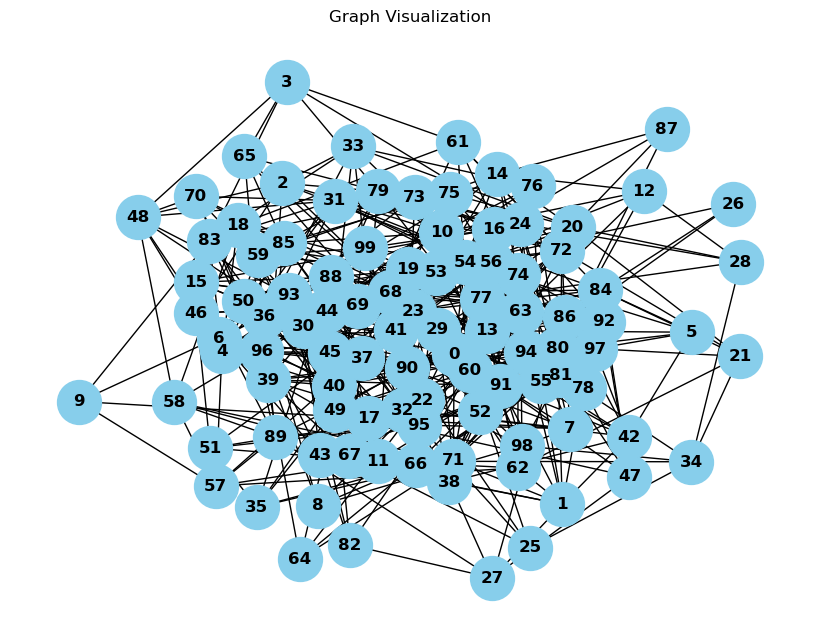

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 78.36it/s]





Elapsed time for node2vec:	41.08 seconds


In [11]:
# Random synthetic network
G = nx.fast_gnp_random_graph(n=100, p=0.1)
print(G)
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold')
plt.title("Graph Visualization")
plt.show()

#  Measure time for unsupervised node2vec training, including both random walk generation and actual learning
start_time = time.time() # begin time measurement

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
node2vec.fit(window=10, min_count=1, batch_words=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

elapsed_time = time.time() - start_time # end time measurement


print("\n\n")
print("Elapsed time for node2vec:\t{:.2f} seconds".format(elapsed_time))

### Measuring storage
Here we will use `tracemalloc` to measure how much storage is used during the node2vec algorithm. `tracemalloc` allows for use of a "snapshot" which contains information about the memory usage for all processes after `tracemalloc.start()` is called. By summing up all provided values, we can measure the total used memory for the *node2vec* algorithm. 

Graph with 100 nodes and 512 edges


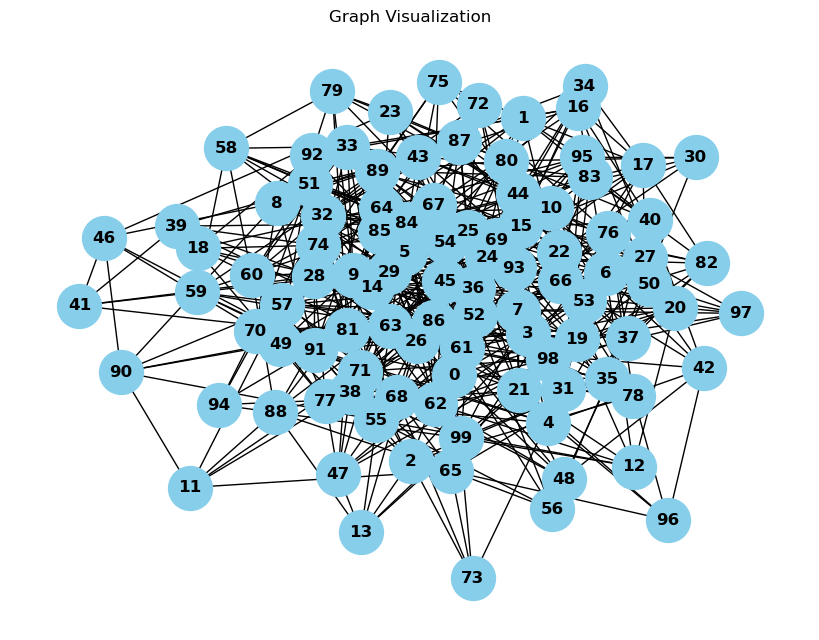

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 81.14it/s]


Total memory used: 75.79 MB


In [12]:
import os
import linecache
import tracemalloc

# using a similar graph as before
G = nx.fast_gnp_random_graph(n=100, p=0.1)
print(G)
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold')
plt.title("Graph Visualization")
plt.show()


tracemalloc.start() # begin measuring memory usage
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
node2vec.fit(window=10, min_count=1, batch_words=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
snapshot = tracemalloc.take_snapshot() # end memory measurement

# Summing every process's memory usage to get total memory
total_size = sum(stat.size for stat in snapshot.statistics('lineno'))

# Converting the total size from bytes to megabytes
total_size_mb = total_size / (1024**2)

print("\n\n")
print(f"Total memory used: {total_size_mb:.2f} MB")


## Generating data
To compare the time and space complexities between *node2vec* and *PecanPy* empirically, we will need to generate enough instances for a significant comparison. This data will be saved to a separate file for further analysis. We will generate 100 small, sparse graphs with 10 nodes each and run both the original *node2vec* and newer *PecanPy* implementations over each of them. The runtimes and memory usages for each of the learning algorithms will be recorded and saved onto a .csv file.
### PecanPy modes
There are a number of modes available for *PecanPy*, with each optimized for different types of networks. The three main modes are `PreComp`, `SparseOTF`, and `DenseOTF`. The creators of *PecanPy* provide the following table to specify the use cases for each: <br>
![PECANPY MODES](pecanpy_table.png) <br>
Because `PreCompFirstOrder` and `FirstOrderUnweighted` were created for specific edgecases, they will not be considered in our analysis. 

### Helper functions

In [3]:
# Helper function for running original node2vec implementation and PecanPy implementations
# and recording elapsed time and memory usage
def measure_algorithm(algorithm, G):
    walks=None
    # Determining which algorithm is being measured,
    # creating the appropriate graph for the algorithm
    if algorithm == "node2vec":
        node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    else:
        g = AdjlstGraph()
        for node in G.nodes():
            g.add_node(node)
        for edge in G.edges():
            g.add_edge(str(edge[0]), str(edge[1]))
        g.save('currentnet.edg')
        if algorithm == "precomp":
            g = pecanpy.PreComp(workers=4, verbose=False)
        elif algorithm == "sparseotf":
            g = pecanpy.SparseOTF(workers=4, verbose=False)
        elif algorithm == "denseotf":
            g = pecanpy.DenseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()
        walks = g.simulate_walks(num_walks=200, walk_length=30) 

    # Beginning measurements
    tracemalloc.clear_traces() # reset memory 
    start_time = time.time() # begin time
    tracemalloc.start() # begin measuring memory usage

    # Beginning training
    if algorithm == "node2vec":
        node2vec.fit(window=10, min_count=1, batch_words=4)
    else:
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)

    # Ending measurements
    current, peak = tracemalloc.get_traced_memory() # end memory
    tracemalloc.clear_traces() # reset memory 
    elapsed_time = time.time() - start_time # end time
    memory_usage = peak / (1024**2)

    # Returning results
    print(algorithm + "\n---------\n" + "Elapsed time: {:.3f} seconds".format(elapsed_time))
    print(f"Memory usage: {memory_usage:.3f} MB")
    print("\n\n")
    return elapsed_time, memory_usage

In [4]:
# Another helper function for generating data,
# uses measure_algorithm to obtain elapsed time and memory usage for an algorithm
def generate_data(filename, n, p, datasize):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["node2vec_time", "node2vec_memory", "precomp_time", "precomp_memory", "SparseOTF_time", "SparseOTF_memory" "DenseOTF_time", "DenseOTF_memory"])
        
        for i in range(datasize):
            
            G = nx.fast_gnp_random_graph(n=n, p=p)
            nx.write_edgelist(G, "currentnet.edgelist")

            print("\t\tSynthetic graph no. " + str(i) + "\n\t\t=======================")
            n2v_time, n2v_memory = measure_algorithm("node2vec", G)
            precomp_time, precomp_memory = measure_algorithm("precomp", G)
            sparseotf_time, sparseotf_memory = measure_algorithm("sparseotf", G)
            denseotf_time, denseotf_memory = measure_algorithm("denseotf", G)
        
            writer.writerow([n2v_time, n2v_memory, precomp_time, precomp_memory, sparseotf_time, sparseotf_memory, denseotf_time, denseotf_memory])
        

In [ ]:
# OLD CODE; REMOVE FROM FINAL SUBMISSION
from pecanpy import pecanpy

with open('small_sparse.csv','w', newline='') as csvfile:
    # Begin writing onto the csv file
    writer = csv.writer(csvfile)
    writer.writerow(["node2vec_time", "node2vec_memory", "precomp_time", "precomp_memory", "SparseOTF_time", "SparseOTF_memory", "DenseOTF_time", "DenseOTF_memory"])

    # Run node2vec and PecanPy algorithms n times each on similar randomly generated graphs (of a given size) and record elapsed times to csv file
    for i in range(100):
        # Synthesize small and sparse graph
        G = nx.fast_gnp_random_graph(n=10, p=0.1)
        nx.write_edgelist(G, "currentnet.edgelist")

        # Running original node2vec implementation and recording elapsed time and memory usage
        node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
        start_time = time.time() # begin time for training with original node2vec implementation
        tracemalloc.start() # begin measuring memory usage
        node2vec.fit(window=10, min_count=1, batch_words=4)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        n2v_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        n2v_memory = total_size / (1024**2)
        print("node2vec total time elapsed: {:.3f} seconds".format(n2v_time))
        print(f"Total memory used: {n2v_memory:.2f} MB")
        print("\n\n")

        # Running all PecanPy implementations and recording elapsed time and memory usage
        # Convert current graph for use with PecanPy
        g = AdjlstGraph()
        for node in G.nodes():
            g.add_node(node)
        for edge in G.edges():
            g.add_edge(str(edge[0]), str(edge[1]))
        g.save('currentnet.edg')

        # PecanPy PreComp implementation
        g = pecanpy.PreComp(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()
        walks = g.simulate_walks(num_walks=200, walk_length=30)           
        
        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        precomp_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        precomp_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(precomp_time))
        print(f"Total memory used: {precomp_memory:.2f} MB")
        print("\n\n")

        #PecanPy SparseOTF implementation
        g = pecanpy.SparseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        sparseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        sparseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(sparseotf_time))
        print(f"Total memory used: {sparseotf_memory:.2f} MB")
        print("\n\n")

        g = pecanpy.DenseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        denseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        denseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(denseotf_time))
        print(f"Total memory used: {denseotf_memory:.2f} MB")
        print("\n\n")

        writer.writerow([n2v_time, n2v_memory, precomp_time, precomp_memory, sparseotf_time, sparseotf_memory, denseotf_time, denseotf_memory])

### Small and sparse graphs
The first use case is for "small and sparse" graphs. With that in mind, we will create synthetic networks containing 10 nodes with a probability of 0.1 for edge creation. 

In [ ]:
generate_data('small_sparse.csv', 10, 0.1, 100)

### Large and Sparse Graphs
The next use case is "large and sparse" graphs, which the authors of *PecanPy* claim to be most appropriate for the `SparseOTF` implementation. Here, we will generate synthetic graphs with 100 nodes and a probability of 0.05 for edge creation, which can be considered sparse for its size. 

In [ ]:
generate_data('large_sparse.csv', 100, 0.05, 100)

### Extremely Dense Graphs
The final case scenario we we will analyze are "extremely dense graphs", which the authors claim are best for the `DenseOTF` algorithm. Because they do not specify any size for this use case, we will make the assumption that `DenseOTF` is best for a graph of moderate size. For this use case, we will synthesize graphs with 50 nodes and a probability of 0.9 for edge creation.  

In [ ]:
generate_data('extremely_dense.csv', 50, 0.9, 100)

<div class="alert alert-block alert-info">
<b>Note:</b> Outputs from the previous codeblocks were removed to maintain brevity. 
</div>

## Analysis
A simple two-sample t-test is sufficent to determine whether the time required for the *PecanPy* implementation is significantly faster than the original *node2vec* implementation. Typically, this can be done in R, but for convience we can do this in python as well. We will use a boxplot alongside the t-test to provide a visual representation of the differences between the two groups. <br> 
> For the t-test, we will define our alpha value as $\alpha = 0.05$

### Small and sparse graphs

#### Time complexity
First, we will conduct a one way analysis of variance to determine if the means of the groups are significantly different from each other. 
> We will define our alpha value as $\alpha = 0.05$

In [18]:
df = pd.read_csv('small_sparse.csv')
alpha = 0.05


f, p = f_oneway(df['node2vec_time'], df['precomp_time'], df['SparseOTF_time'], df['DenseOTF_time'])
print("f-value: \t", f)
print("p-value: \t", p)

f-value: 	 1044.6659078070577
p-value: 	 1.1487336485961139e-187


Because the calculated p-value is far below our alpha of $0.05$, we can safely conclude that at least one of the means of the four groups is significantly different from the others. From here, we can use boxplots to determine where each of the algorithms stand in relation to each other. 

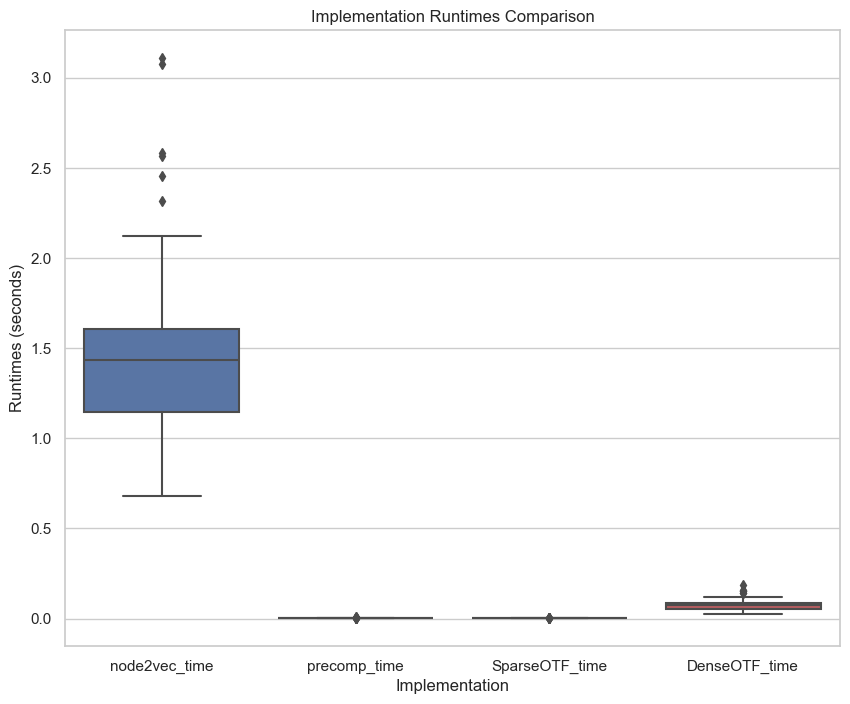

In [32]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['node2vec_time', 'precomp_time', 'SparseOTF_time', 'DenseOTF_time']])

box_plot.set_title('Implementation Runtimes Comparison')
box_plot.set_xlabel('Implementation')
box_plot.set_ylabel('Runtimes (seconds)')

plt.show()

The above plot makes it obvious that node2vec is clearly significantly different from each of the *PecanPy* implementations, but it is unclear how the *PecanPy* implementations differ from each other. So, we will plot a box plot with only the three *PecanPy* implementations.

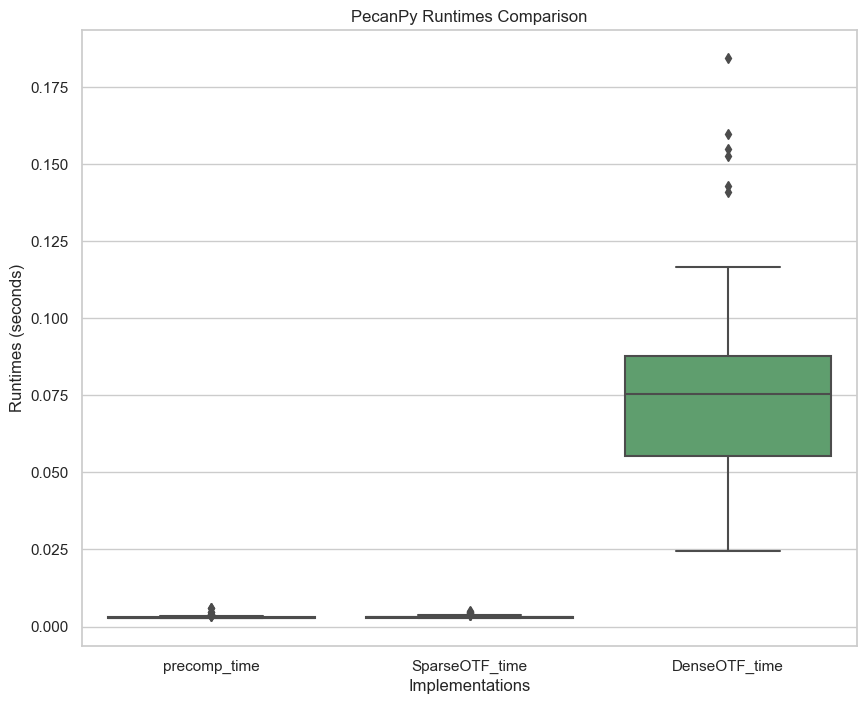

In [19]:
plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['precomp_time', 'SparseOTF_time', 'DenseOTF_time']])

box_plot.set_title('PecanPy Runtimes Comparison')
box_plot.set_xlabel('Implementations')
box_plot.set_ylabel('Runtimes (seconds)')

plt.show()

Once again, it is obvious that `DenseOTF` takes significantly longer than both `Precomp` and `SparseOTF`, as `DenseOTF`'s entire boxplot is above the other two implementations' boxplots. So, to determine whether `Precomp` and `SparseOTF` differ from each other significantly, we will use a t-test. 

In [20]:
t, p = t_stat, p_value = ttest_ind(df['precomp_time'], df['SparseOTF_time'])
print("t-statistic:\t", t)
print("p-value:\t", p)

t-statistic:	 -0.7550684121089234
p-value:	 0.4511051422452089


Because the p-value is far above our originally indicated alpha value of $0.05$, we will conclude that `Precomp` and `SparseOTF` runtimes are not significantly different for small and sparse graphs. 

#### Memory usage
To analyze the differences in memory usage between the different implementations, we will follow the same process. We will begin with an ANOVA test, and move onto boxplots and t-tests as needed.

In [30]:
df = pd.read_csv('small_sparse.csv')
alpha = 0.05


f, p = f_oneway(df['node2vec_memory'], df['precomp_memory'], df['SparseOTF_memory'], df['DenseOTF_memory'])
print("f-value: \t", f)
print("p-value: \t", p)

f-value: 	 4841.87001248494
p-value: 	 1.33026723513e-311


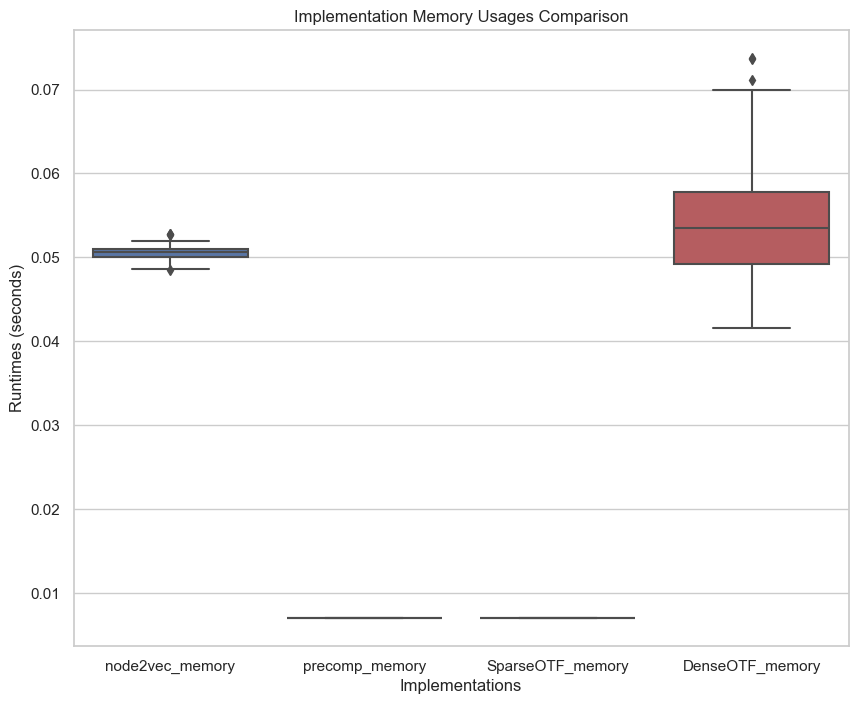

In [31]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['node2vec_memory', 'precomp_memory', 'SparseOTF_memory', 'DenseOTF_memory']])

box_plot.set_title('Implementation Memory Usages Comparison')
box_plot.set_xlabel('Implementations')
box_plot.set_ylabel('Runtimes (seconds)')

plt.show()

In [23]:
t, p = t_stat, p_value = ttest_ind(df['precomp_memory'], df['SparseOTF_memory'])
print("t-statistic:\t", t)
print("p-value:\t", p)

t-statistic:	 0.0
p-value:	 1.0


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


The previous results indicate that the original *node2vec* implemenation and `DenseOTF` use significantly more storage than the other implementations, but the variance of `DenseOTF` is much higher (as seen from the boxplot). The subsequent t-test between the memory usage of `Precomp` and `SparseOTF` indicates that the two implementations are so similar that they use essentially the same amount of storage during runtime.

### Large and Sparse Graphs
We will follow the exact same process as before to determine the differences in runtimes and memory usage for each implementation in the context of extremely dense graphs. 
#### Time Complexity

In [40]:
df = pd.read_csv('large_sparse.csv')
alpha = 0.05


f, p = f_oneway(df['node2vec_time'], df['precomp_time'], df['SparseOTF_time'], df['DenseOTF_time'])
print("f-value: \t", f)
print("p-value: \t", p)

f-value: 	 4142.85284714858
p-value: 	 1.3998436174697855e-298


Text(0, 0.5, 'Runtimes (seconds)')

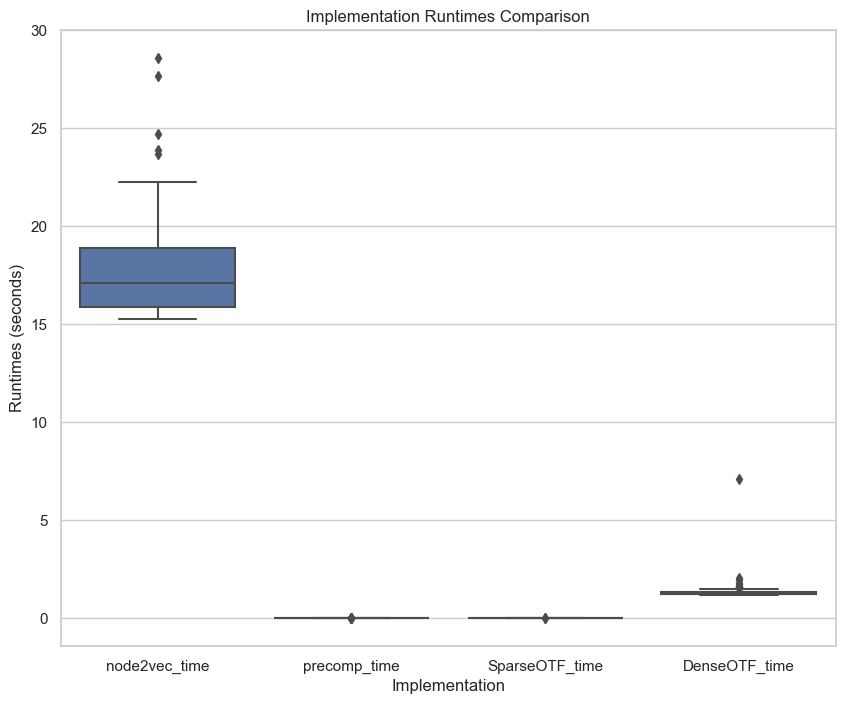

In [41]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['node2vec_time', 'precomp_time', 'SparseOTF_time', 'DenseOTF_time']])

box_plot.set_title('Implementation Runtimes Comparison')
box_plot.set_xlabel('Implementation')
box_plot.set_ylabel('Runtimes (seconds)')

Text(0, 0.5, 'Runtimes (seconds)')

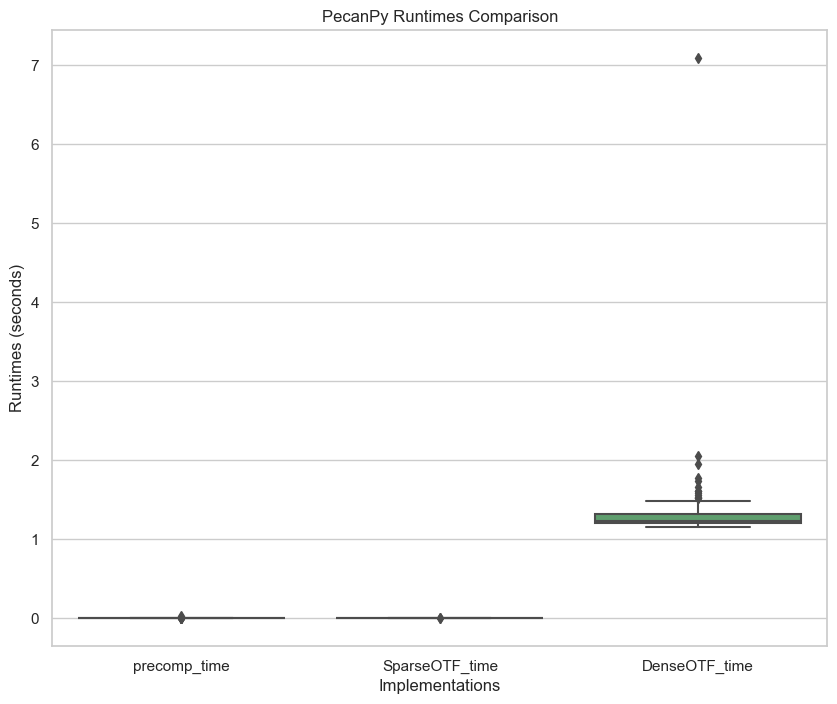

In [42]:
plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['precomp_time', 'SparseOTF_time', 'DenseOTF_time']])

box_plot.set_title('PecanPy Runtimes Comparison')
box_plot.set_xlabel('Implementations')
box_plot.set_ylabel('Runtimes (seconds)')

In [43]:
t, p = t_stat, p_value = ttest_ind(df['precomp_time'], df['SparseOTF_time'])
print("t-statistic:\t", t)
print("p-value:\t", p)

t-statistic:	 0.5021274297188862
p-value:	 0.6161358267743386


The results indicate that the *PecanPy* runtimes are significantly lower than the original *node2vec* implementation, with `Precomp` and `SparseOTF` begin the fastest. 

In [44]:
df = pd.read_csv('extremely_dense.csv')
alpha = 0.05


f, p = f_oneway(df['node2vec_memory'], df['precomp_memory'], df['SparseOTF_memory'], df['DenseOTF_memory'])
print("f-value: \t", f)
print("p-value: \t", p)

f-value: 	 10286.563007917886
p-value: 	 0.0


Text(0, 0.5, 'Runtimes (seconds)')

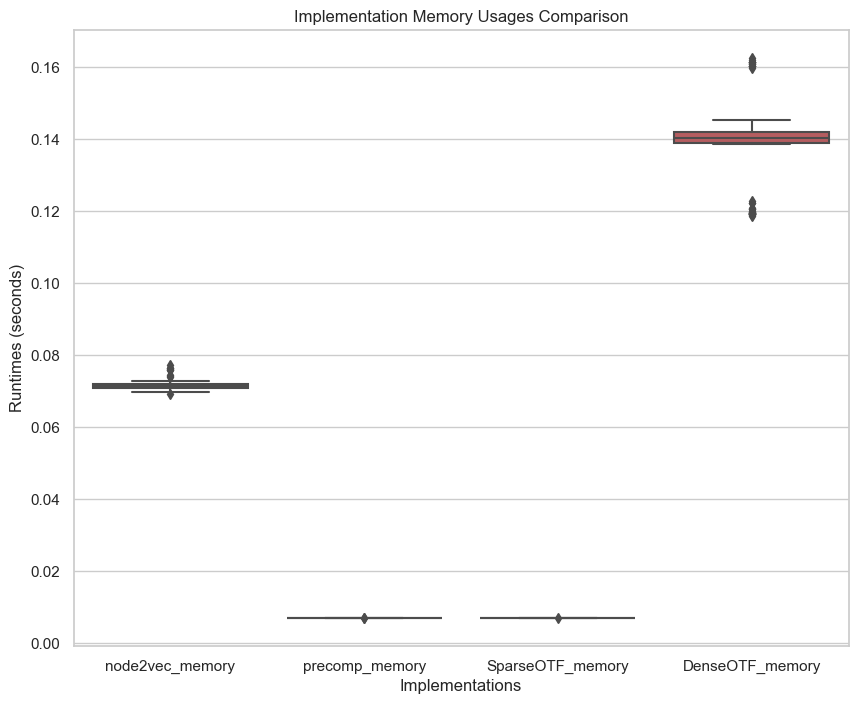

In [45]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['node2vec_memory', 'precomp_memory', 'SparseOTF_memory', 'DenseOTF_memory']])

box_plot.set_title('Implementation Memory Usages Comparison')
box_plot.set_xlabel('Implementations')
box_plot.set_ylabel('Runtimes (seconds)')

From the boxplots we can see that each of the implementation's storage uses are significantly different from each other, with `Precomp` and `SparseOTF` using the least amount of memory and `DenseOTF` using the most. 

### Extremely Dense Graphs
We will follow the exact same process as before to determine the differences in runtimes and memory usage for each implementation in the context of extremely dense graphs. 
#### Time Complexity

In [33]:
df = pd.read_csv('extremely_dense.csv')
alpha = 0.05


f, p = f_oneway(df['node2vec_time'], df['precomp_time'], df['SparseOTF_time'], df['DenseOTF_time'])
print("f-value: \t", f)
print("p-value: \t", p)

f-value: 	 1406.6505272531288
p-value: 	 1.0049735525918053e-210


Text(0, 0.5, 'Runtimes (seconds)')

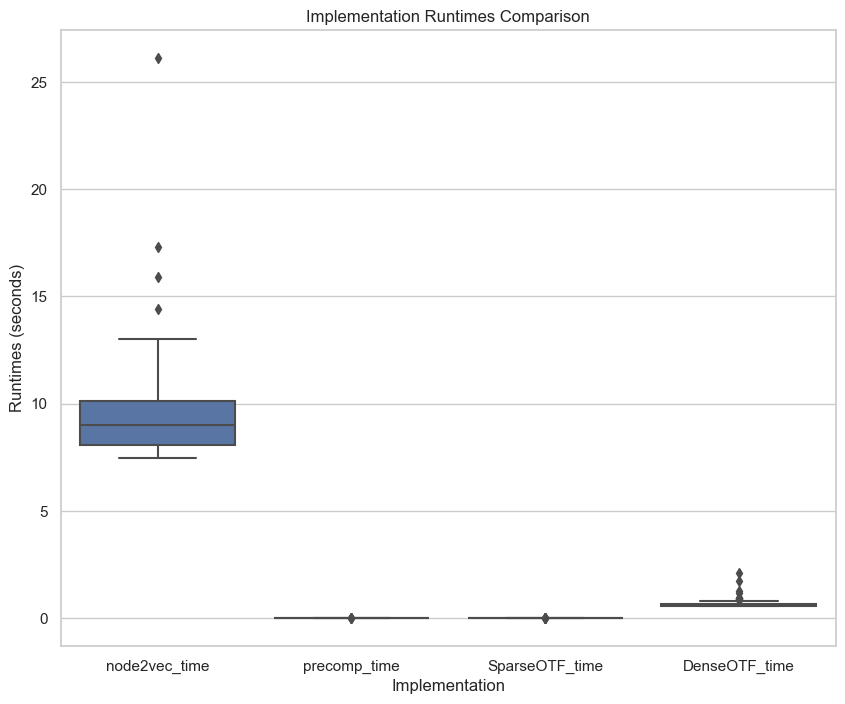

In [34]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['node2vec_time', 'precomp_time', 'SparseOTF_time', 'DenseOTF_time']])

box_plot.set_title('Implementation Runtimes Comparison')
box_plot.set_xlabel('Implementation')
box_plot.set_ylabel('Runtimes (seconds)')

Text(0, 0.5, 'Runtimes (seconds)')

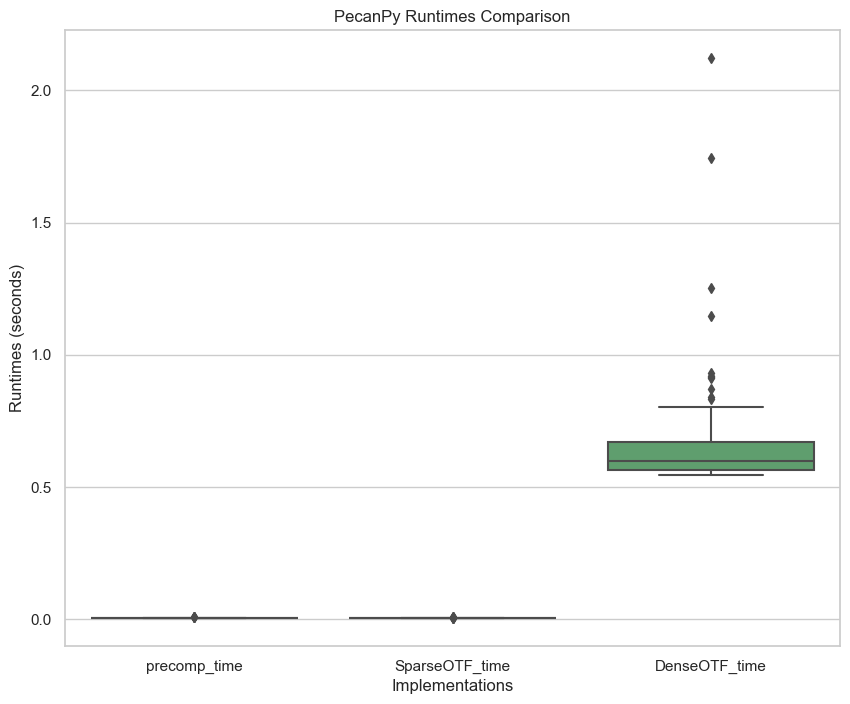

In [35]:
plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['precomp_time', 'SparseOTF_time', 'DenseOTF_time']])

box_plot.set_title('PecanPy Runtimes Comparison')
box_plot.set_xlabel('Implementations')
box_plot.set_ylabel('Runtimes (seconds)')

In [36]:
t, p = t_stat, p_value = ttest_ind(df['precomp_time'], df['SparseOTF_time'])
print("t-statistic:\t", t)
print("p-value:\t", p)

t-statistic:	 3.347751328297016
p-value:	 0.0009750445437123099


Text(0, 0.5, 'Runtimes (seconds)')

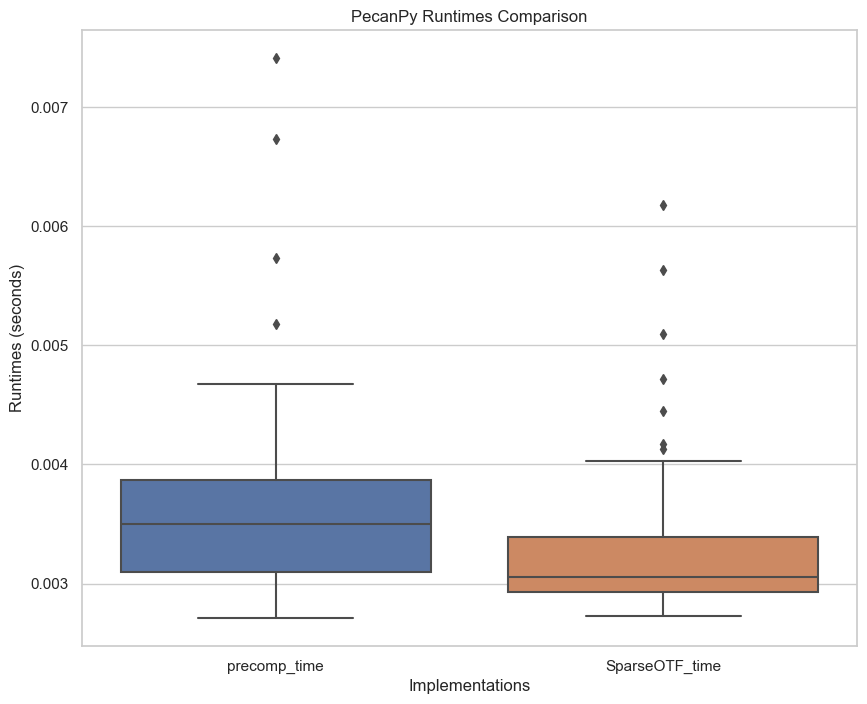

In [37]:
plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['precomp_time', 'SparseOTF_time']])

box_plot.set_title('PecanPy Runtimes Comparison')
box_plot.set_xlabel('Implementations')
box_plot.set_ylabel('Runtimes (seconds)')

These results indicate that `SparseOTF` has the lowest runtimes of all implementations. Although, its runtimes may be significantly different from `Precomp`'s runtimes, it is likely not *practically* significant at this level, as it seems to be a distinction that is under 0.001 seconds. Further research could expand upon whether this difference has any practical effects with extremely large graphs, like social networks. 

#### Memory usage

In [38]:
df = pd.read_csv('extremely_dense.csv')
alpha = 0.05


f, p = f_oneway(df['node2vec_memory'], df['precomp_memory'], df['SparseOTF_memory'], df['DenseOTF_memory'])
print("f-value: \t", f)
print("p-value: \t", p)

f-value: 	 10286.563007917886
p-value: 	 0.0


Text(0, 0.5, 'Runtimes (seconds)')

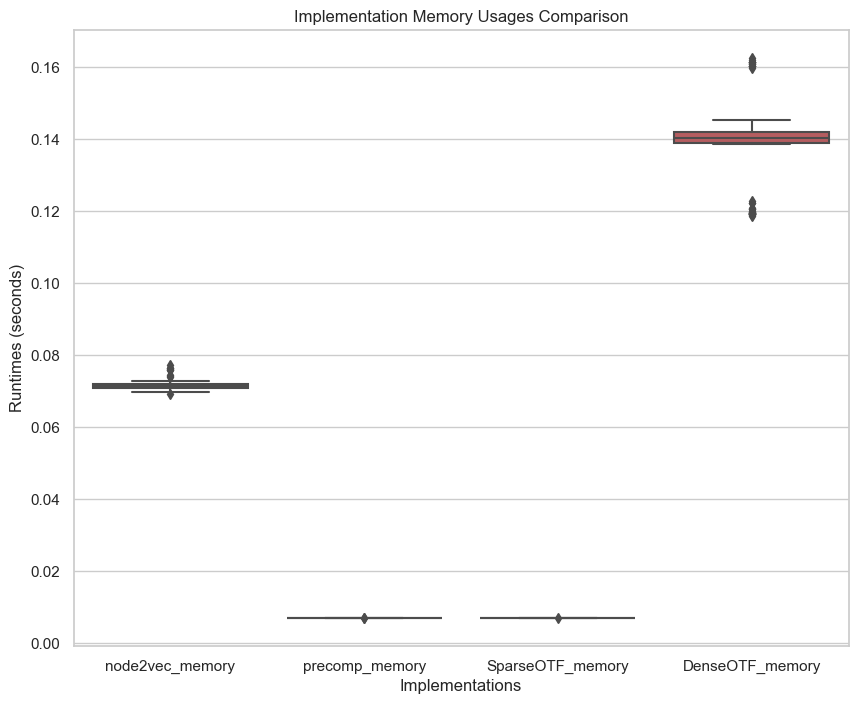

In [39]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data=df[['node2vec_memory', 'precomp_memory', 'SparseOTF_memory', 'DenseOTF_memory']])

box_plot.set_title('Implementation Memory Usages Comparison')
box_plot.set_xlabel('Implementations')
box_plot.set_ylabel('Runtimes (seconds)')

Similar to the results from large and sparse graphs, these results indicate that each implementation's memory usage is significantly different from each others, with `DenseOTF` using the most memory and `Precomp` and `SparseOTF` using the least.

## Conclusion
Given that the t-test resulted in a p-value much lower than our originally stated alpha value of 0.05, we can reject the null hypothesis and conclude that the time required for the *PecanPy* implementation is significantly lower than the *node2vec* implementation. Therefore, we have evidence to suggest that **the newer *PecanPy* implementation is an *improvement* over the original *node2vec* implementation**